In [106]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import numpy as np

# Helper Plotting utility functions.
def set_axes(ylim=[-0.1, 1.1], xlim=[0.3, 1.05]):
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.yticks([])
    plt.xticks([])

def to_prob(x):
    return 1/(1+np.exp(-x))

def plot_all(xs, intrinsic_ris, treated_risk,
            p_treats, colors, linestyles):
    # Theoretical Risk
    intrinsic_risk_prob = np.array(to_prob(intrinsic_risk))
    treated_risk_prob = np.array(to_prob(treated_risk))

    fig = plt.figure(figsize=(6, 4))
    plt.plot(xs, intrinsic_risk_prob, color=colors["untreated"], linestyle="-")
    plt.plot(xs, treated_risk_prob, color=colors["treated"], linestyle="-")
    set_axes()

    # Treatment Protocols
    for protocol_type in ["strict", "loose"]:
        fig = plt.figure(figsize=(6, 4))
        plt.plot(xs,
                 p_treats[protocol_type]["optimal"],
                 color=colors["optimal"],
                 linestyle=linestyles["optimal"])
        for alternative in ["too_low", "too_high"]:
            plt.plot(xs,
                 p_treats[protocol_type][alternative],
                 color=colors[alternative],
                 linestyle=linestyles[alternative])#[protocol_type])
        set_axes()

    # Observed Risks
    def plot_observed_risk(p_treat, untreated_risk,
                           treated_risk, color, linestyle):
        observed_risk = (1-p_treat)*untreated_risk+p_treat*treated_risk
        plt.plot(
            xs, 
            observed_risk,
            color=color,
            alpha=0.8,
            linestyle=linestyle
        )
        return observed_risk
    for protocol_type in ["strict", "loose"]:
    
        fig = plt.figure(figsize=(6, 4))
        observed_optimal = plot_observed_risk(
            p_treats[protocol_type]["optimal"], 
            intrinsic_risk_prob,
            treated_risk_prob,
            colors["optimal"],
            linestyles["optimal"]
        )
        for alternative in ["too_low", "too_high"]:
            observed_protocol = plot_observed_risk(
                p_treats[protocol_type][alternative], 
                intrinsic_risk_prob,
                treated_risk_prob,
                colors[alternative],
                linestyles[alternative]#[protocol_type]
            )
            idxs_fill = np.where(observed_protocol > observed_optimal)
            plt.fill_between(
                xs[idxs_fill],
                observed_optimal[idxs_fill],
                observed_protocol[idxs_fill],
                observed_protocol[idxs_fill], 
                color=colors[alternative],
                alpha=0.2
            )
        set_axes()
        plt.show()

font = {
    'weight' : 'normal',
    'size' : 22
}
matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=4, linestyle='-.')

colors={
    "optimal": 'black',
    "too_low": 'green',
    "too_high": 'orange',
    "untreated": 'red',
    'treated': 'blue'
}
linestyles = {
    "optimal": "-",
    "too_low": "--",
    "too_high": "-.",
    "loose": "--",
    "strict": "-."
}

def sigmoid(max_val, slope, midpoint):
    return max_val / (1 + np.exp(-slope*(xs - midpoint)))

In [107]:
xs = np.linspace(0.35, 1, 1000)
# Define the risk without treatment.
def intrinsic(slope, midpoint, xs=xs):
    parabola = 2*slope*(xs - midpoint)**2
    return parabola - np.mean(parabola)
intrinsic_risk = intrinsic(10, 0.5)

print(np.percentile(intrinsic_risk, 75))
print(np.percentile(intrinsic_risk, 50))

def constant_benefit(intrinsic_risk):
    return intrinsic_risk - np.percentile(intrinsic_risk, 75)
def cap_risk(intrinsic_risk):
    return np.minimum(intrinsic_risk, np.percentile(intrinsic_risk, 50))
def constant_risk(intrinsic_risk):
    return np.ones_like(intrinsic_risk)*np.percentile(intrinsic_risk, 50)
def move_x():
    return intrinsic(10, 0.5, xs-0.2)

strict_thresh_slope = 500
guidance_slope  = 20

def run_simulation(treated_risk, optimal_threshold=None):
    if optimal_threshold is None:
        optimal_threshold = xs[np.where(treated_risk < intrinsic_risk)[0][0]]
    p_treats_strict = {
        "too_low": sigmoid(1, strict_thresh_slope, optimal_threshold-0.2),
        "optimal": sigmoid(1, strict_thresh_slope, optimal_threshold),
        "too_high": sigmoid(1, strict_thresh_slope, optimal_threshold+0.2)
    }
    p_treats_loose = {
        "too_low": sigmoid(1, guidance_slope, optimal_threshold-0.2),
        "optimal": sigmoid(1, guidance_slope, optimal_threshold),
        "too_high": sigmoid(1, guidance_slope, optimal_threshold+0.2)
    }
    p_treats = {
        "strict": p_treats_strict,
        "loose": p_treats_loose,
    }
    plot_all(xs, intrinsic_risk, treated_risk,
                p_treats, colors, linestyles)

0.9600501778054333
-0.7055742930117306


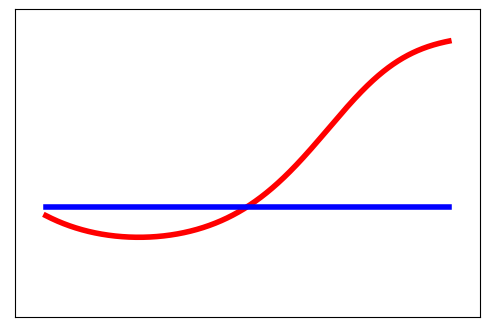

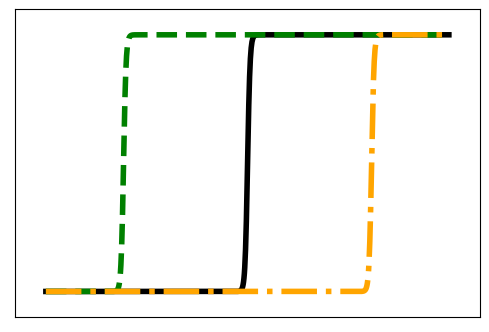

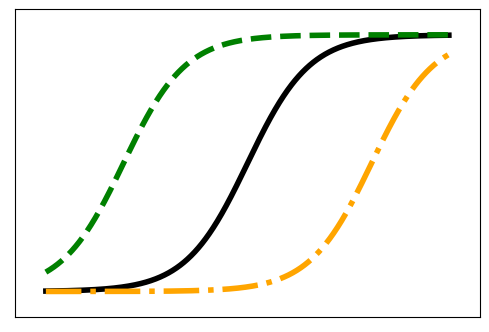

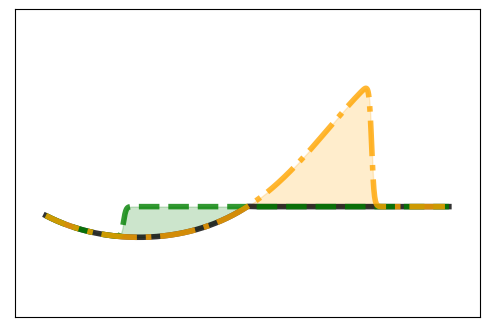

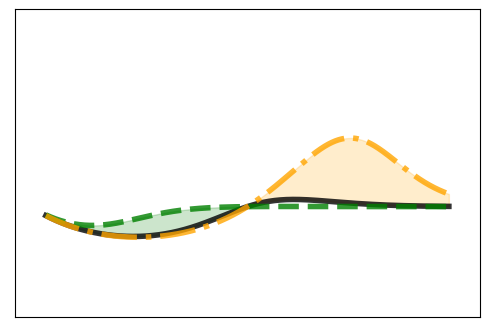

In [108]:
run_simulation(constant_risk(intrinsic_risk))

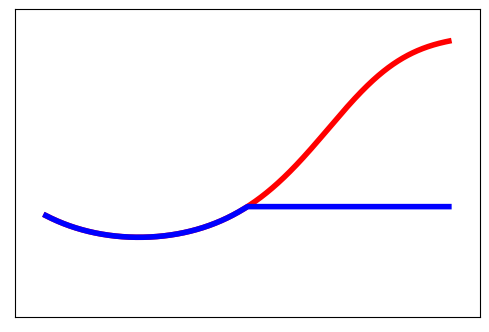

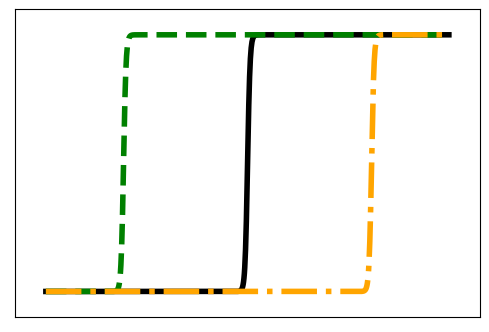

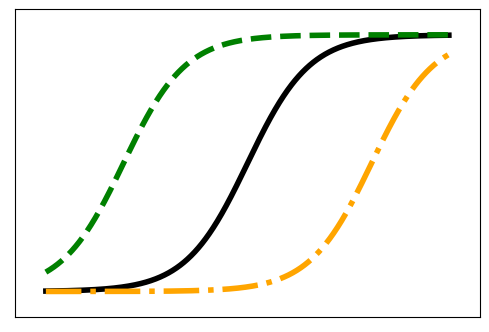

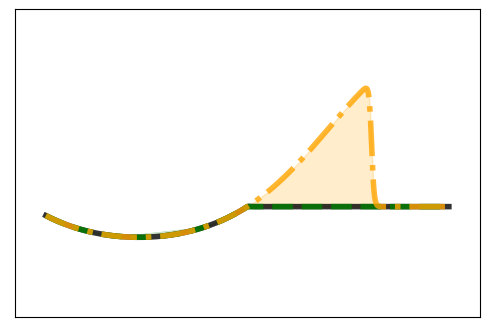

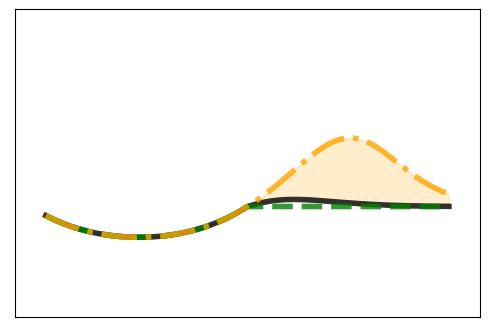

In [109]:
run_simulation(cap_risk(intrinsic_risk))

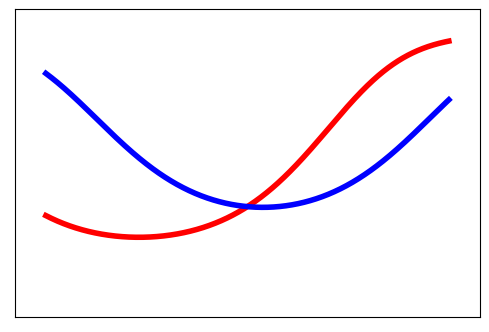

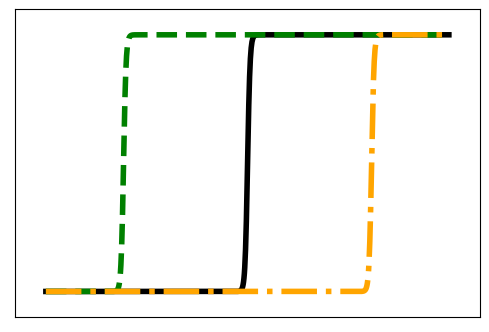

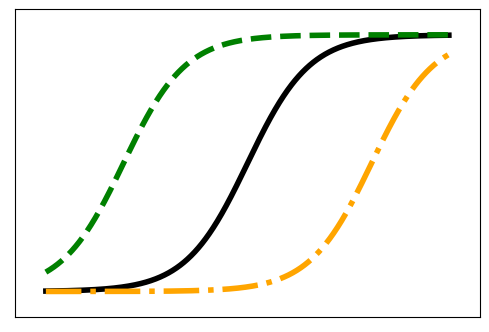

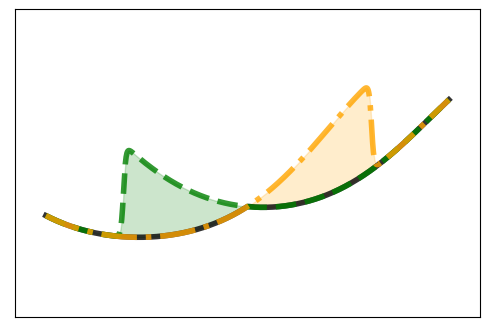

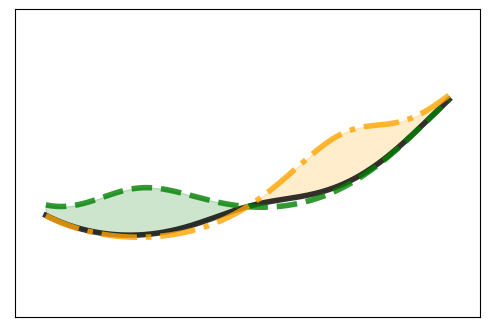

In [110]:
run_simulation(move_x())

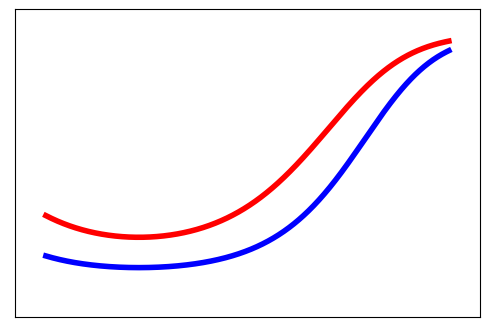

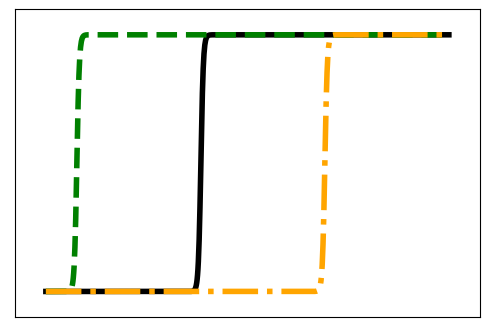

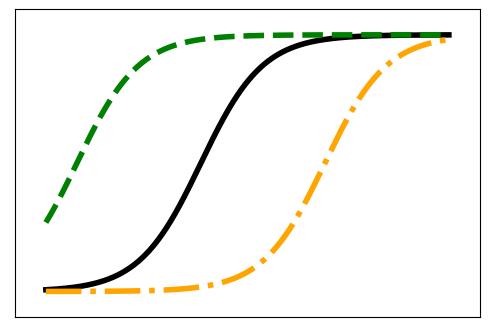

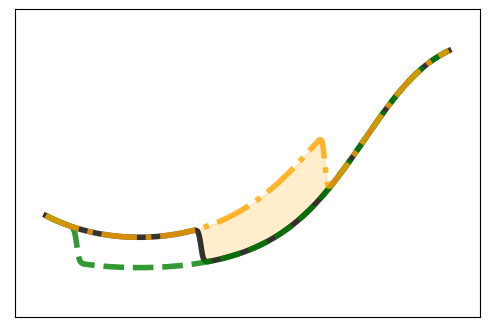

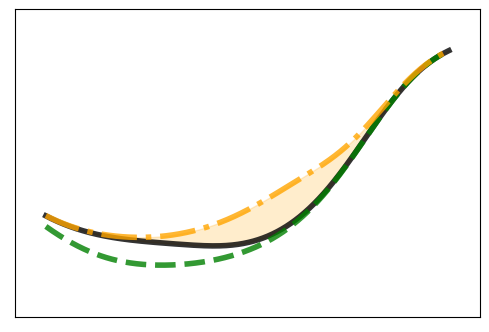

In [111]:
# Constant Benefit -- Idealized Treatment.
treated_risk = constant_benefit(intrinsic_risk)
run_simulation(treated_risk, optimal_threshold=0.6)